## **To recreate study results please load package versions found in main_requirements.txt**

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mp
import math
import seaborn as sns
import os

# less common imports
from sklearn import preprocessing
from scipy.stats import f
from sklearn.cluster import AgglomerativeClustering
import matplotlib.cm as cm

# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

scanpy==1.6.0 anndata==0.7.4 umap==0.4.3 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.8.0


In [2]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import new_misc_code as nmc 

## **Load anndata and GAM fit stage gene trends**

In [3]:
# read in anndata for obs
adata = sc.read_h5ad( "../data/post-gaba-wt-dev-traj.h5ad")

In [4]:
n_splines = 12
n_grid_pts = 100
good_fits = nmc.load_obj( f"../data/STAGE_gam_fits_{n_splines}_grid{n_grid_pts}.pkl")
logTMMs = nmc.load_obj( f"../data/logTMMs.pkl")

## **Hierarchical Trend Clustering**

In [5]:
# concat all trajectories into one dataframe 
all_goods_df = pd.concat( list( good_fits.values()), keys=list(good_fits.keys()))
all_goods_df.index.names = ['cell_type', 'gene']

In [6]:
all_goods_df.head()

0         1         2         3         4   \
cell_type gene                                                              
Astro     RP4-669L17.10  3.730370  3.732293  3.734472  3.736986  3.739916   
          HES4           7.842602  7.834160  7.825038  7.815024  7.803907   
          B3GALT6        3.795677  3.812004  3.827499  3.841902  3.854954   
          SCNN1D         2.638892  2.663214  2.687655  2.712253  2.737046   
          MORN1          3.943980  3.947700  3.951340  3.954875  3.958281   

                               5         6         7         8         9   \
cell_type gene                                                              
Astro     RP4-669L17.10  3.743342  3.747342  3.751997  3.757387  3.763591   
          HES4           7.791474  7.777514  7.761815  7.744166  7.724355   
          B3GALT6        3.866397  3.875970  3.883414  3.888471  3.890881   
          SCNN1D         2.762069  2.787361  2.812959  2.838900  2.865221   
          MORN1          3.961531  3.964602  3.967468  3.970105  3.972488   

                         ...        90        91        92        93  \
cell_type gene           ...                                           
Astro     RP4-669L17.10  ...  5.219550  5.220805  5.221135  5.220631   
          HES4           ...  5.541086  5.539305  5.537916  5.536883   
          B3GALT6        ...  2.154405  2.134264  2.113933  2.093431   
          SCNN1D         ...  4.575473  4.572910  4.569755  4.566066   
          MORN1          ...  4.859608  4.859932  4.859217  4.857564   

                               94        95        96        97        98  \
cell_type gene                                                              
Astro     RP4-669L17.10  5.219384  5.217483  5.215021  5.212086  5.208770   
          HES4           5.536165  5.535726  5.535525  5.535525  5.535687   
          B3GALT6        2.072775  2.051984  2.031078  2.010074  1.988993   
          SCNN1D         4.561902  4.557319  4.552377  4.547133  4.541645   
          MORN1          4.855075  4.851852  4.847996  4.843610  4.838796   

                               99  
cell_type gene                     
Astro     RP4-669L17.10  5.205163  
          HES4           5.535973  
          B3GALT6        1.967851  
          SCNN1D         4.535971  
          MORN1          4.833654  

[5 rows x 100 columns]

In [7]:
# image formatting
cmap = sns.color_palette( "ch:start=.2,rot=-.3", n_colors=1_000)
sns.set_context( context='paper')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})

/scratchfs/cherring/brain_maturation/bm_project_env/main_bm/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


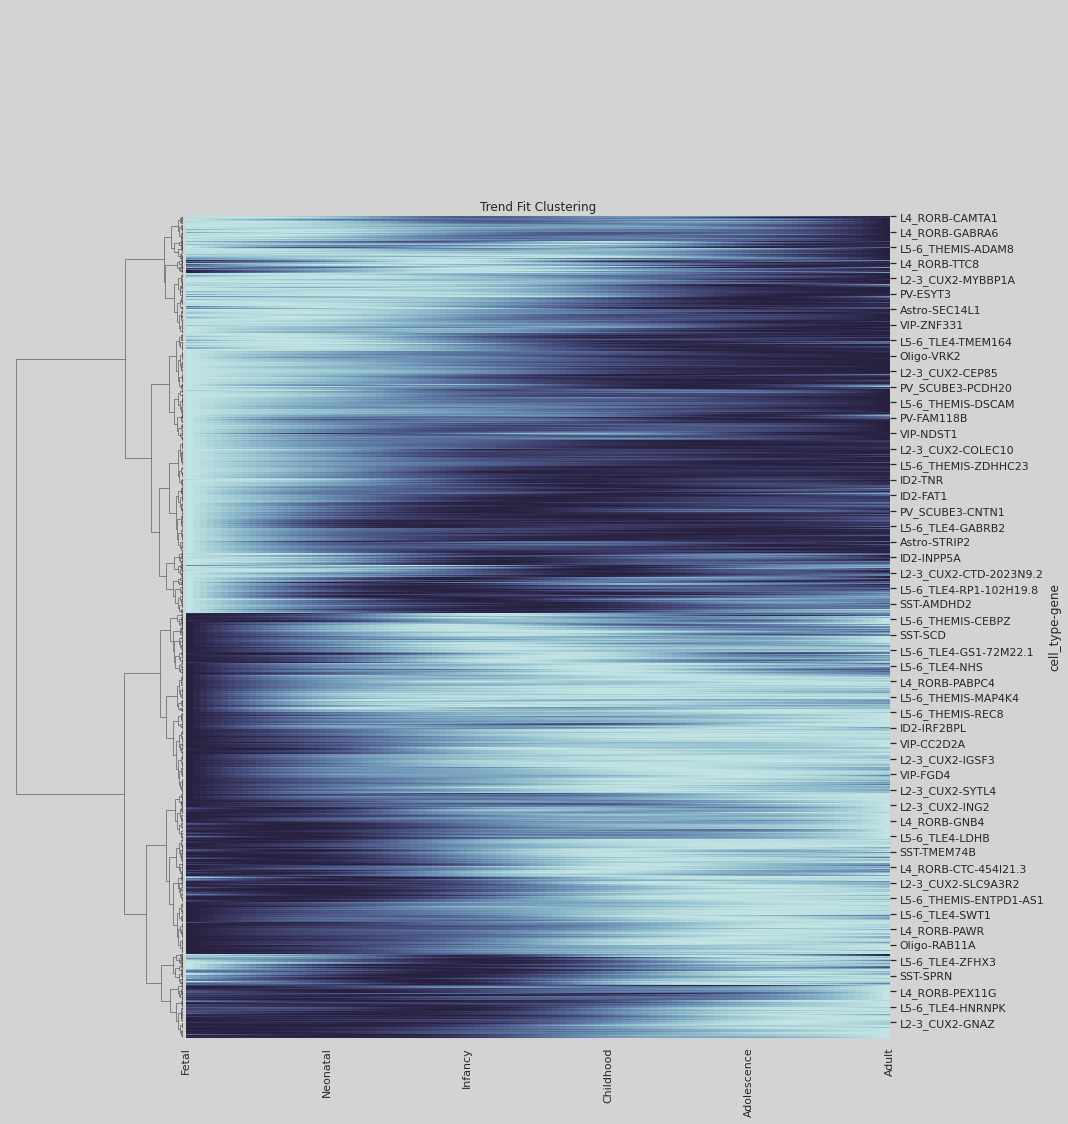

In [8]:
# using seaborn clustermap, which uses scipy hierarchical clustering
# this will take a while to run
ax = sns.clustermap( all_goods_df, metric='euclidean', method='ward', col_cluster=False, row_cluster=True, cmap=cmap, figsize=(15,15), standard_scale=0)
ax.cax.set_visible(False)
num_stages = len( adata.uns['stage_order'])
ticks = np.linspace(0, all_goods_df.shape[1], num_stages)
ax.ax_heatmap.set_xticks( ticks);
ax.ax_heatmap.set_xticklabels( adata.uns['stage_order'], rotation=90);
ax.ax_row_dendrogram.set_visible(True)
plt.setp( ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
ax.ax_heatmap.set_title( "Trend Fit Clustering");

In [9]:
# set colors used in manuscript
tttt = cm.get_cmap('tab20', 20)
tab20 = []
for i in range(tttt.N):
    rgba = tttt(i)
    tab20.append( mp.colors.rgb2hex(rgba))
# tab20

In [10]:
from scipy.cluster import hierarchy
# get scipy dendrogram from seaborn
dend_link = ax.dendrogram_row.linkage
# cut dendrogram tree
cut_tree = hierarchy.cut_tree( dend_link, height=90).squeeze()
u_clusts = np.unique( cut_tree)

# ***Trend clusters were renumbered in manuscript for readability so current format does not match manuscript numbering***
### **See Renaming_tables.xlsx in code home directory for label matching**

In [11]:
# dataframe of traj genes and cluster membership, if wanted for further analysis
devDEGs_df = pd.DataFrame()
devDEGs_df['major_clust'] = [ii[0] for ii in all_goods_df.index]
devDEGs_df['gene_name']   = [ii[1] for ii in all_goods_df.index]
devDEGs_df['gene_trend']  = cut_tree
devDEGs_df.head()

major_clust      gene_name  gene_trend
0       Astro  RP4-669L17.10           0
1       Astro           HES4           1
2       Astro        B3GALT6           2
3       Astro         SCNN1D           3
4       Astro          MORN1           0

In [12]:
# devDEGs_df.to_csv('../data/gene_cluster_ids.csv')

In [13]:
# get row_order for plotting avg cluster trends later
row_order = (hierarchy.leaves_list( dend_link))
# get cluster order
_, idx = np.unique( cut_tree[row_order], return_index=True)
clust_order = cut_tree[row_order][np.sort(idx)]
# order of clusters top to bottom
clust_order

array([ 7, 12,  0,  3,  6, 11,  5,  8,  9,  1,  2, 10, 13,  4])

In [14]:
# format cluster colors for plotting
lut = dict( zip( clust_order, tab20))
row_colors = pd.Series( cut_tree).map( lut)

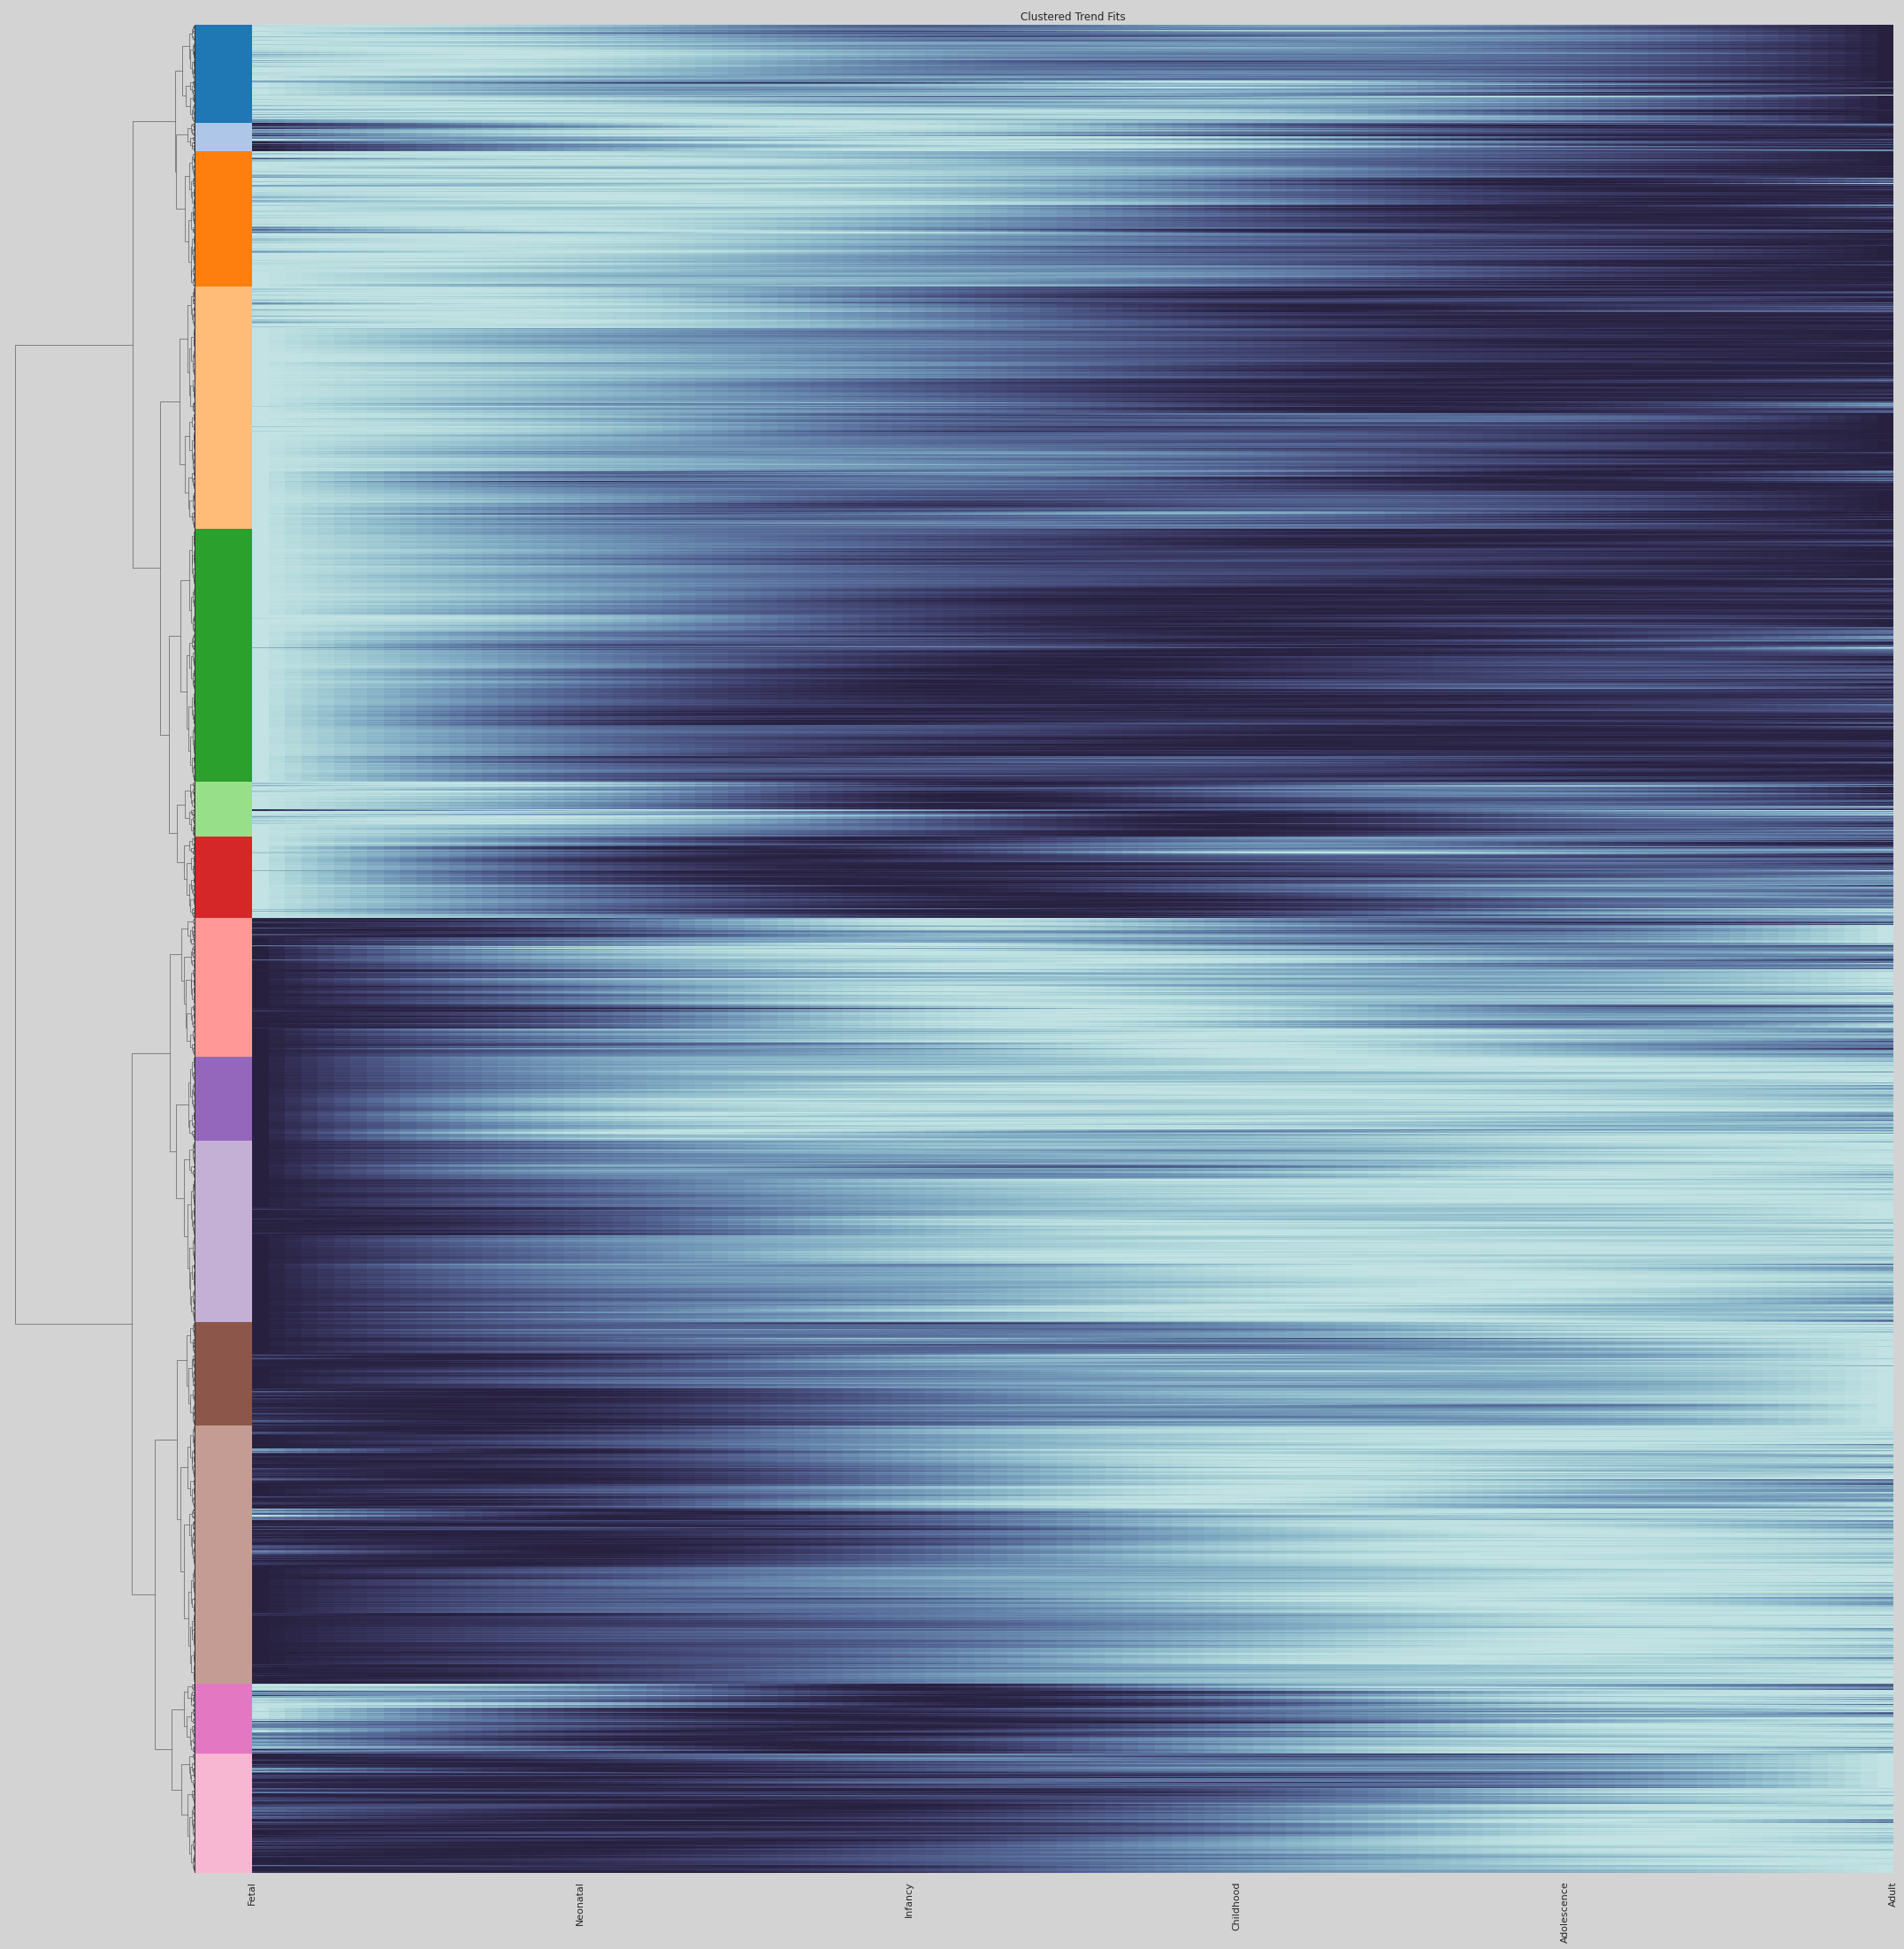

In [15]:
ax = sns.clustermap( all_goods_df.reset_index(drop=True), row_linkage=dend_link, row_colors=row_colors, col_cluster=False, 
                     row_cluster=True, cmap=cmap, figsize=(30,30), standard_scale=0, 
                     yticklabels=[], cbar_pos=None, dendrogram_ratio=(0.10,0.01))
num_stages = len( adata.uns['stage_order'])
ticks = np.linspace(0, all_goods_df.shape[1], num_stages)
ax.ax_heatmap.set_xticks( ticks);
ax.ax_heatmap.set_xticklabels( adata.uns['stage_order'], rotation=90);
ax.ax_row_dendrogram.set_visible(True)
plt.setp( ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
ax.ax_heatmap.set_title( "Clustered Trend Fits");

In [16]:
# generalized trends
down       = ['9','1','2','10','4']
inter_down = ['12','8']
inter_up   = ['13','11','5']
up         = ['7','0','3','6']

### **Figure 2D Gene trend plots**

In [22]:
# genes can be list/array of ints or gene names 
def plot_tend_avg( genes, trend_df, scat_df, color='green', alpha=1.0):
    min_max_scaler = preprocessing.MinMaxScaler()
    plt.figure( figsize=(4.625*3,4.625)) #, facecolor='white')
    # plot trend fit
    trends = trend_df.loc[genes,:]
    norm_td = min_max_scaler.fit_transform( trends.T)
    avg_td = np.mean( norm_td, axis=1)
    plt.plot( norm_td, linewidth=1.0, alpha=0.01, color=color)
    plt.plot( avg_td, linewidth=2.5, alpha=alpha, color='black')

    num_stages = len( adata.uns['stage_order'])
    ticks = np.linspace(0, n_grid_pts, num_stages)
    plt.xticks( ticks, [""]*len(ticks))
    return

7 3320
12 975
0 4613
3 8247
6 8590
11 1874
5 2782
8 4708
9 2853
1 6173
2 3520
10 8790
13 2372
4 4062


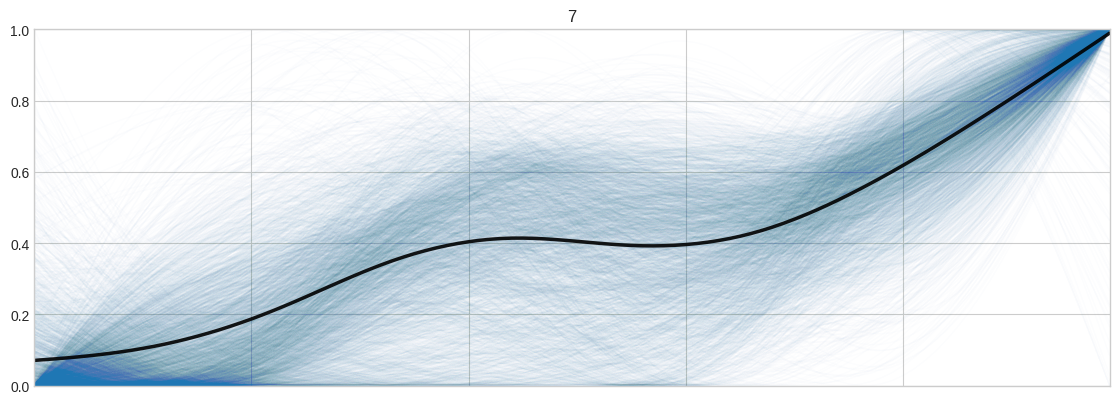

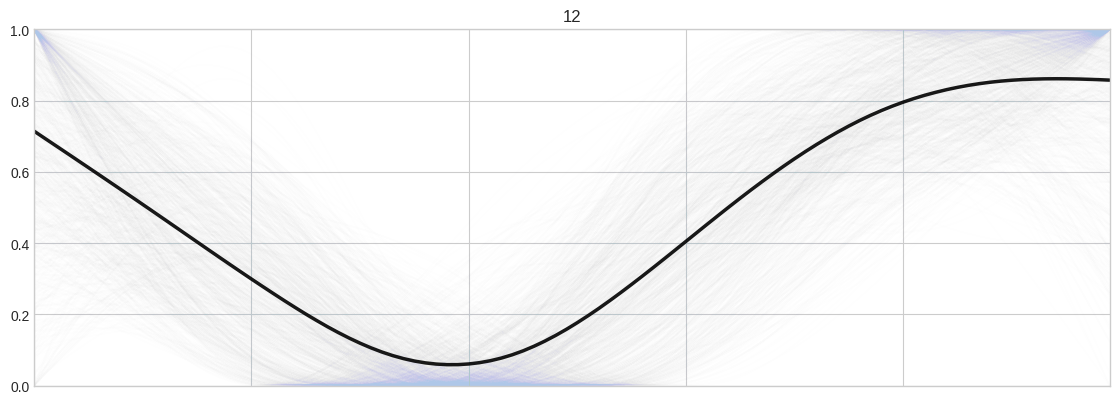

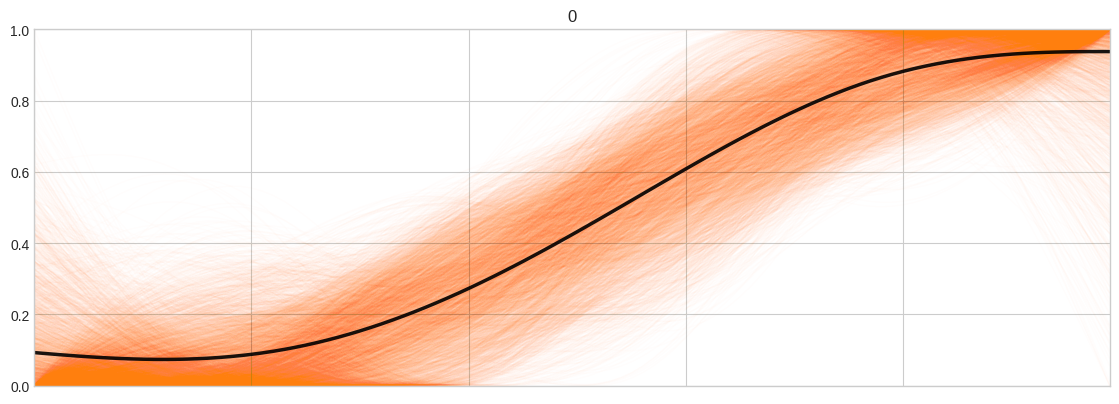

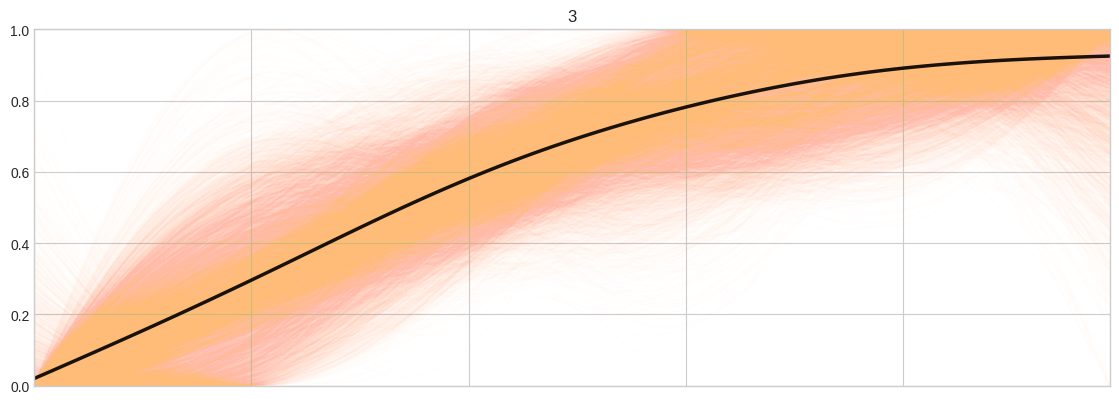

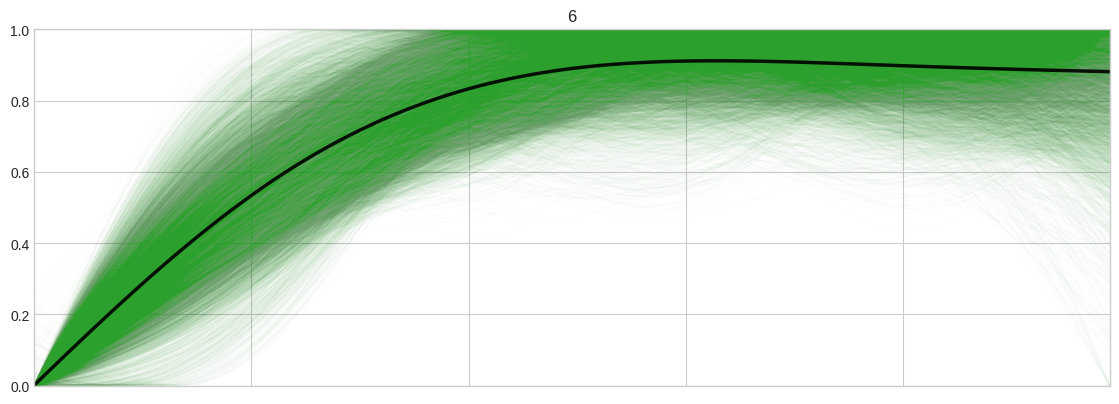

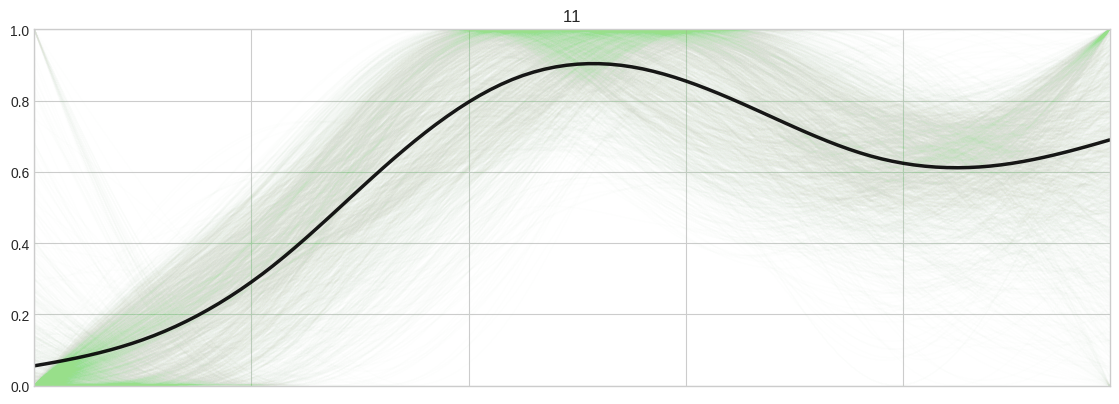

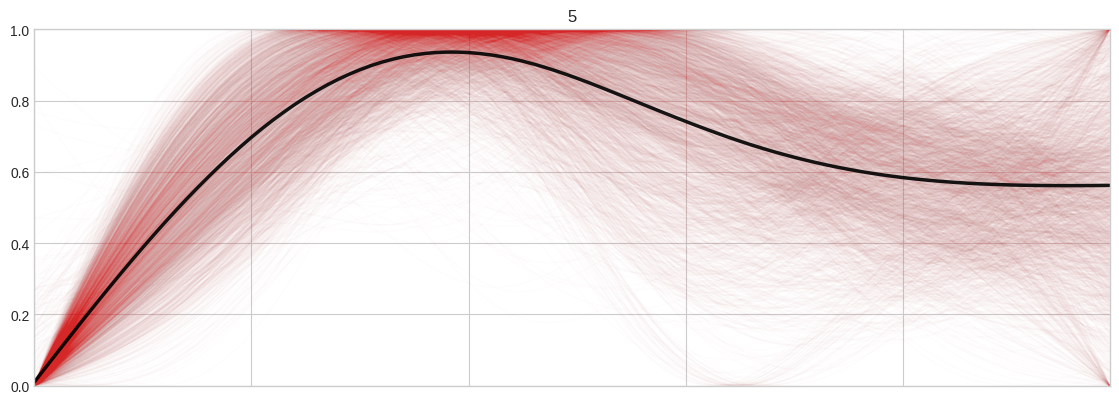

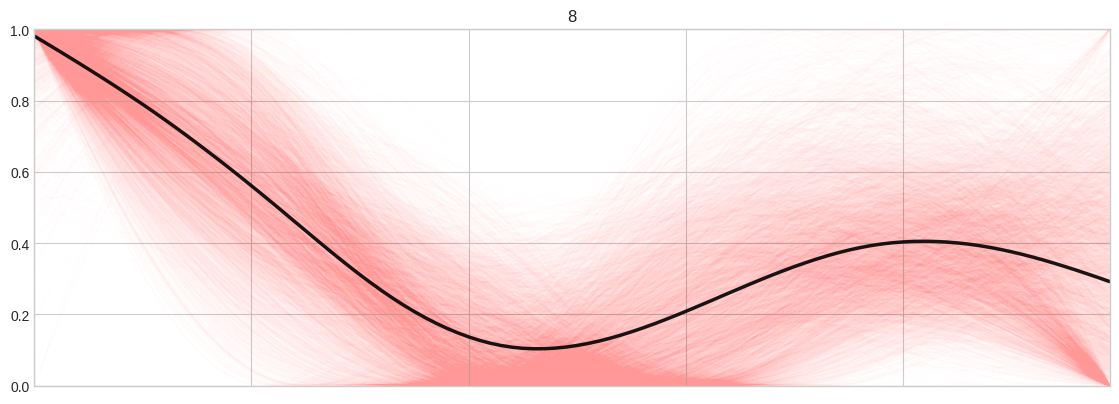

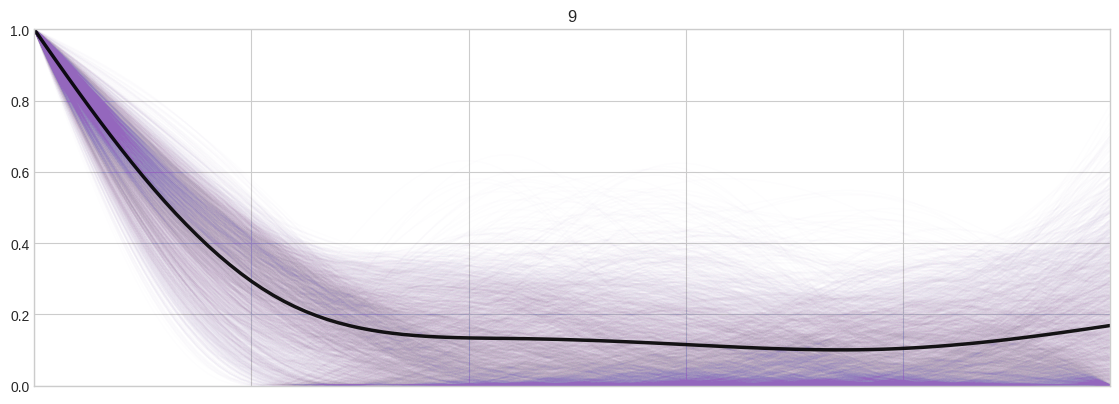

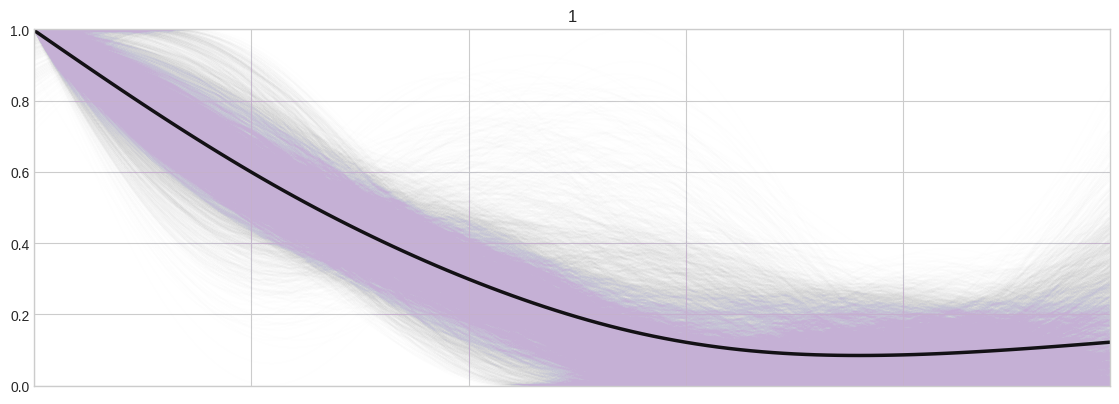

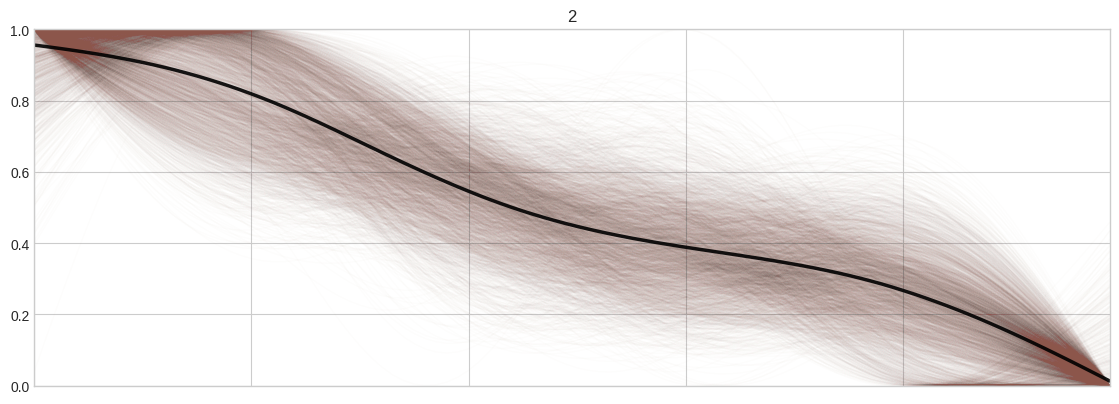

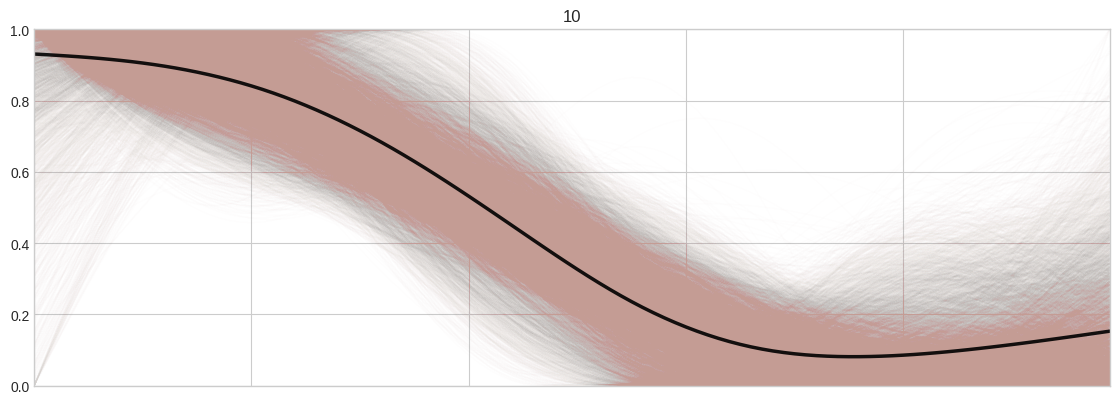

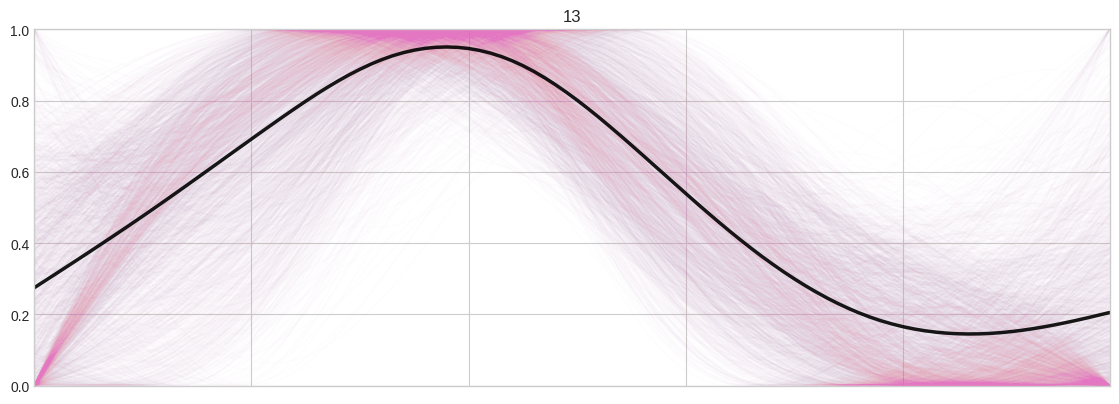

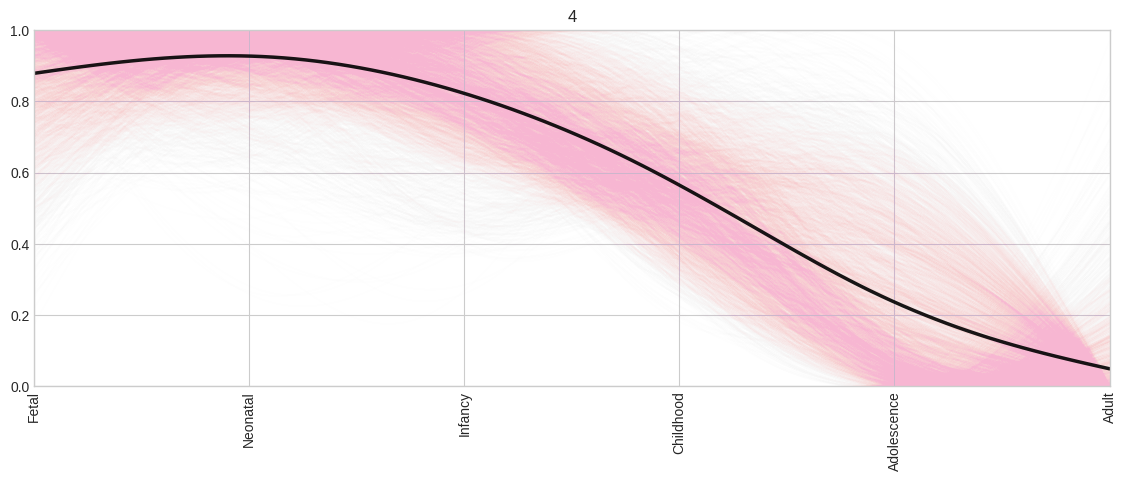

In [23]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.style.use('seaborn-whitegrid')
# plt.rcParams['axes.facecolor'] = 'white'
for clust_itr in clust_order:
    clust_mk = cut_tree==clust_itr
    print( clust_itr, sum(clust_mk))
    clust_genes = all_goods_df.index[clust_mk]
    plot_tend_avg( clust_genes, all_goods_df, logTMMs['L2-3_CUX2'], alpha=0.9, color=lut[clust_itr])
    plt.title( clust_itr)
    plt.ylim(0.0,1.0)
    plt.xlim(0,n_grid_pts-1)
    # plt.savefig( f"../path/out/trend-clust_height-90_{clust_itr}_trend-plots.png", format='png', bbox_inches='tight')num_stages = len( np.unique( logTMMs['L4_RORB'].columns))
ticks = np.linspace(0, n_grid_pts-1, num_stages)
plt.xticks( ticks=ticks, labels=adata.uns['stage_order'], rotation=90);
# have to the last one to get x-labels
# plt.savefig( f"../path/out/trend-clust_height-90_{clust_itr}_trend-plots.png", format='png', bbox_inches='tight')

In [26]:
ctype_df = pd.DataFrame( [], index=mj_order, columns=clust_order, dtype=int)
ctype_df[:] = 0
# loop through each cluster   
for clust_itr in clust_order:
    clust_mk = cut_tree==clust_itr
    clust_genes = all_goods_df.index[clust_mk]
    clust_df = all_goods_df.loc[clust_genes,:]
    # loop through each cell_type
    for cell_itr in all_goods_df.index.unique(level='cell_type'):
        # get genes in each combo
        if( cell_itr not in clust_df.index.unique( level='cell_type')):
            continue
        else:
            cell_df = clust_df.loc[cell_itr]
            ctype_df.loc[cell_itr,clust_itr] = cell_df.shape[0]
        # get counts for each cell_type and cluster
#         print( clust_itr, cell_itr)

In [27]:
layer_tots = ctype_df.sum(1).values
ctype_df = ctype_df.divide( layer_tots, axis='rows')*100

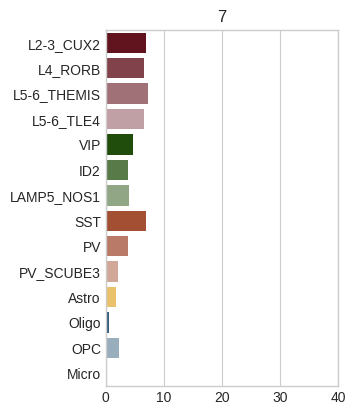

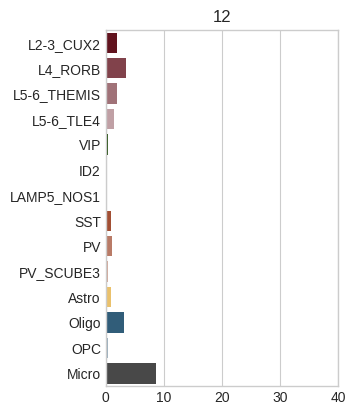

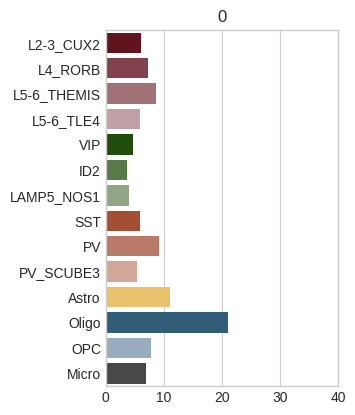

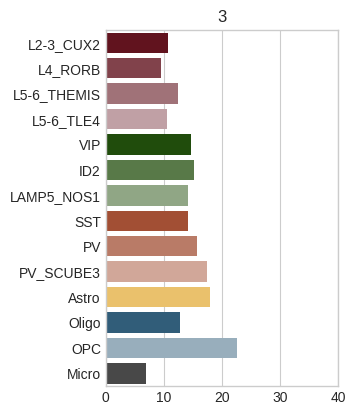

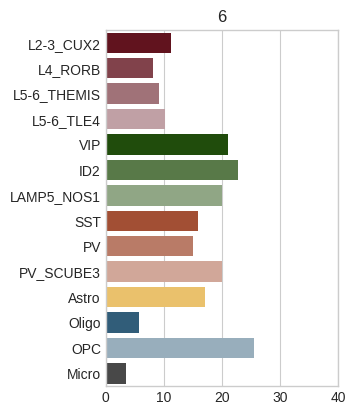

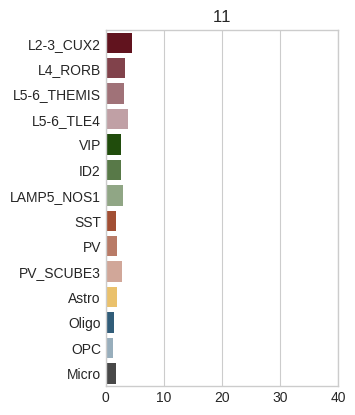

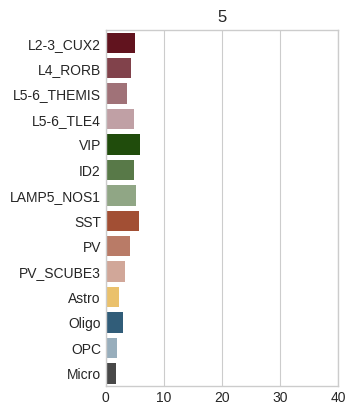

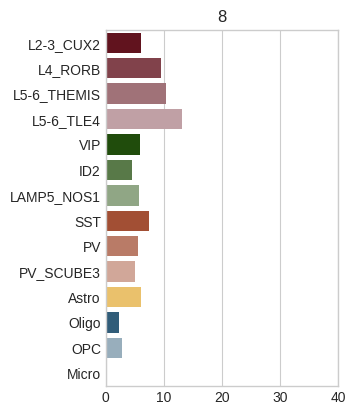

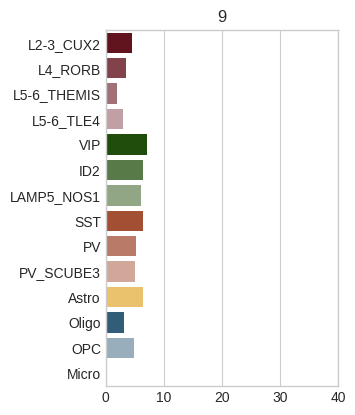

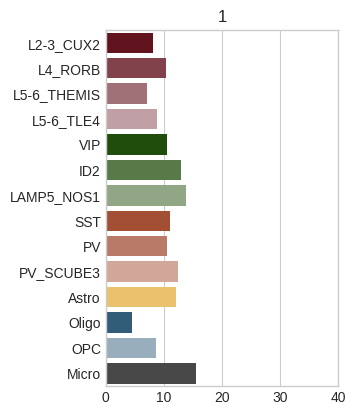

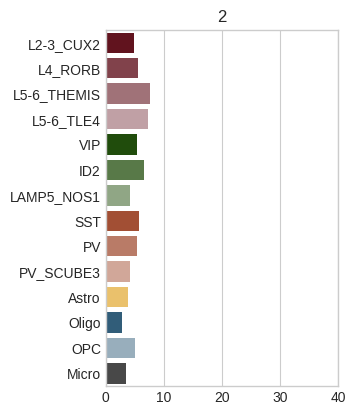

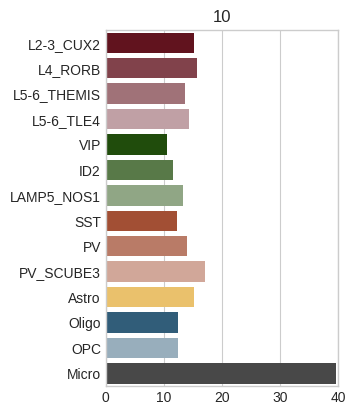

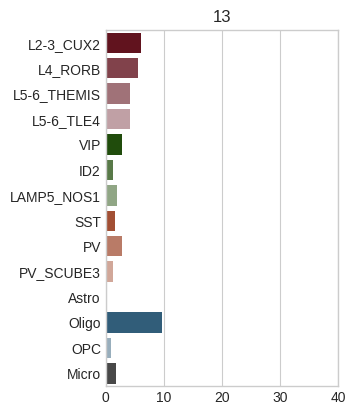

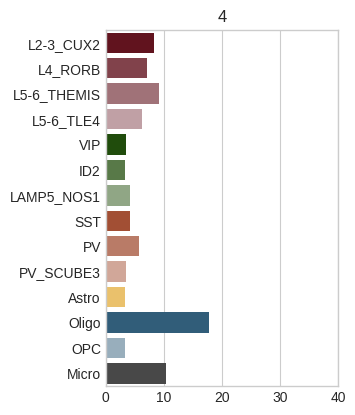

In [30]:
# po = [color_dict[ii] for ii in mj_order]
for itr in ctype_df.columns.values:
    fig, ax = plt.subplots(1, 1, figsize=(3,4.625))
    # ADDED: Remove labels
    sns.barplot( y=ctype_df.index, 
                 x=ctype_df.loc[:,itr], 
#                  hue_order=mj_order, 
#                  order=mj_order, 
                 palette=adata.uns['major_clust_colors_dict'], 
                 ax=ax);
#     ax.set_ylabel('')    
    ax.set_xlabel('')
#     ax.set_yticklabels('')
    plt.title( itr);
    plt.xlim(0,40)
#     plt.savefig( f"../data/mj-clusts-gene-clust_height-90_{itr}_bar-plots.png", format='png', bbox_inches='tight')